# Preprocessing an audio dataset

## Resampling the audio data

In [2]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")

In [3]:
from datasets import Audio

minds = minds.cast_column(
    "audio",
    Audio(sampling_rate=16_000)
)

In [4]:
minds[0]

{'path': 'C:\\Users\\placasa\\.cache\\huggingface\\datasets\\downloads\\extracted\\e0ec044e7ce839a98c449eb0ae1ba96bb351ad48044ecd3bcfeead1365376a56\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\placasa\\.cache\\huggingface\\datasets\\downloads\\extracted\\e0ec044e7ce839a98c449eb0ae1ba96bb351ad48044ecd3bcfeead1365376a56\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19284673e-04, ...,
         9.40908678e-04, 1.16613181e-03, 7.20883720e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

## Filtering the dataset

In [5]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [6]:
import librosa

# Use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# Use Datasets' "filter" method to apply the filtering function
minds = minds.filter(
    is_audio_length_in_range,
    input_columns=["duration"]
)

# Remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter: 100%|██████████| 654/654 [00:00<00:00, 65386.03 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

## Pre-processing audio data

In [7]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(
    "openai/whisper-small"
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
c:\Users\placasa\AppData\Local\miniconda3\envs\huggingface_audio_course_py311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\placasa\.cache\huggingface\hub\models--openai--whisper-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggin

In [8]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"],
        sampling_rate=audio["sampling_rate"],
        padding=True
    )
    return features

In [9]:
minds = minds.map(prepare_dataset)
minds

Map: 100%|██████████| 624/624 [01:05<00:00,  9.57 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

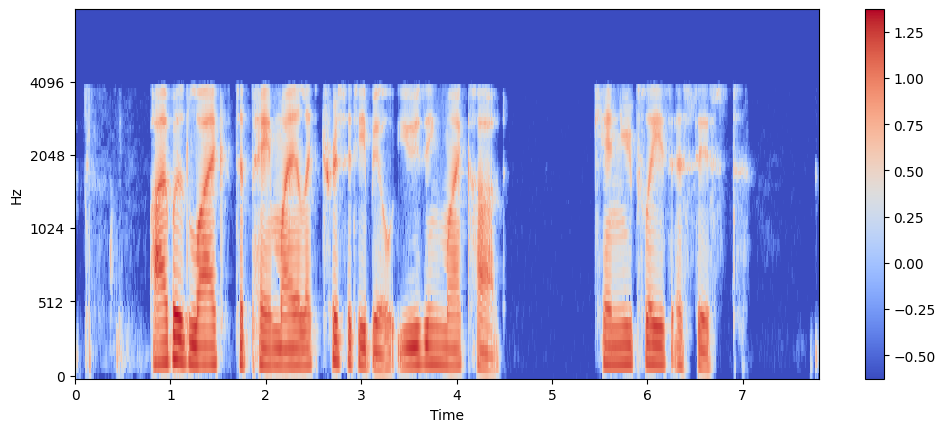

In [10]:
import numpy as np
import matplotlib.pyplot as plt

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length
)
plt.colorbar()

In [11]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(
    "openai/whisper-small"
)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
